This notebook shows how to trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review.   In our POC, there are 68 classes ofL1 and  318 classes of L2, so it is much complex than the notebook , but we can run POC with the same workflow as the notebook. 

This notebook uses the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews.

IMDb lets users rate movies on a scale from 1 to 10, but the dataset only has positive and negative reviews. 

- negative review : score≤4
- positive review : score≥7

## Text Classification Workflow

Here is a standard workflow of text classification workflow. 

![Topic classification](images/text_classfication_workflow.png)

In order to simplify the steps, they can be splitted to two stages.

- Data Preparation 
  - Gather  Data: collect enough and good quality data.
  - Explore Data: 
  - Prepare Data:
- Model Construction
  - Build, Train & Evaluate Model
  - Tune Hyper-Parameters
  - Deploy Model

## Gather Data

Before starting, let's import the packages that we will use.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import random
import shutil
import string
import tensorflow as tf

from collections import Counter
from sklearn.feature_extraction import text
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# restrict the memory of GPU to 1GB
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
print(gpus)
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]
)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Download data 

Let's download and extract IMDB dataset.

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url, untar=True)
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

print(dataset)

/root/.keras/datasets/aclImdb_v1.tar.gz


![image-20201217095446441](images/image-20201217095446441.png)

Explore the directory structure.

![image-20201104115404253](images/image-20201104115404253.png)

There are 2 folders which have the data.

- train: train data
- test: test data

### View data

Let's count how many positive and negative comments.

In [3]:
def get_files(base_dir):
    pos_dir = os.path.join(base_dir, 'pos')
    pos_files = os.listdir(pos_dir)
    pos_files = [os.path.join(pos_dir, file_name) for file_name in pos_files]
    
    neg_dir = os.path.join(base_dir, 'neg')
    neg_files = os.listdir(neg_dir)
    neg_files = [os.path.join(neg_dir, file_name) for file_name in neg_files]    

    return pos_files, neg_files

train_pos_files, train_neg_files = get_files(os.path.join(dataset_dir, 'train'))
test_pos_files, test_files = get_files(os.path.join(dataset_dir, 'test'))
    
print('train dataset: {} positive reviews, {} negative reviews'.format(len(train_pos_files), len(train_neg_files)))
print('test dataset: {} positive reviews, {} negative reviews'.format(len(test_pos_files), len(test_files)))

train dataset: 12500 positive reviews, 12500 negative reviews
test dataset: 12500 positive reviews, 12500 negative reviews


![image-20201217115036617](images/image-20201217115036617.png)

Below are some positive reviews.

In [4]:
for file_path in train_pos_files[0:3]:    
    print('-'*30 + file_path + '-'*30 )
    with open(file_path) as f:
        comment = f.read() 
        print(comment if len(comment)<=800 else comment[0:800]+' ...')  

------------------------------/root/.keras/datasets/aclImdb/train/pos/127_7.txt------------------------------
Zentropa has much in common with The Third Man, another noir-like film set among the rubble of postwar Europe. Like TTM, there is much inventive camera work. There is an innocent American who gets emotionally involved with a woman he doesn't really understand, and whose naivety is all the more striking in contrast with the natives.<br /><br />But I'd have to say that The Third Man has a more well-crafted storyline. Zentropa is a bit disjointed in this respect. Perhaps this is intentional: it is presented as a dream/nightmare, and making it too coherent would spoil the effect. <br /><br />This movie is unrelentingly grim--"noir" in more than one sense; one never sees the sun shine. Grim, but intriguing, and frightening.
------------------------------/root/.keras/datasets/aclImdb/train/pos/126_10.txt------------------------------
Zentropa is the most original movie I've seen in y

![image-20201217111649607](images/image-20201217111649607.png)

Below are some negative reviews.

In [5]:
for file_path in train_neg_files[0:3]:    
    print('-'*30 + file_path + '-'*30 )
    with open(file_path) as f:
        comment = f.read() 
        print(comment if len(comment)<=800 else comment[0:800]+' ...') 

------------------------------/root/.keras/datasets/aclImdb/train/neg/127_4.txt------------------------------
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher ...
------------------------------/root/.keras/datasets/aclImdb/train/neg/126_1.txt------

## Explore Data

Let's explore the data further. Understanding the characteristics of your data beforehand will enable you to build a better model. 

### Basic Information

First, we load the entire dataset.

In [6]:
def load_imdb_sentiment_analysis_dataset(imdb_data_path, seed=123):
    """Loads the IMDb movie reviews sentiment analysis dataset.

    # Arguments
        data_path: string, path to the data directory.
        seed: int, seed for randomizer.

    # Returns
        A tuple of training and validation data.
        Number of training samples: 25000
        Number of test samples: 25000
        Number of categories: 2 (0 - negative, 1 - positive)

    # References
        Mass et al., http://www.aclweb.org/anthology/P11-1015

        Download and uncompress archive from:
        http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    """

    # Load the training data
    train_texts = []
    train_labels = []
    for category in ['pos', 'neg']:
        train_path = os.path.join(imdb_data_path, 'train', category)
        for fname in sorted(os.listdir(train_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(train_path, fname)) as f:
                    train_texts.append(f.read())
                train_labels.append(0 if category == 'neg' else 1)

    # Load the validation data.
    test_texts = []
    test_labels = []
    for category in ['pos', 'neg']:
        test_path = os.path.join(imdb_data_path, 'test', category)
        for fname in sorted(os.listdir(test_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(test_path, fname)) as f:
                    test_texts.append(f.read())
                test_labels.append(0 if category == 'neg' else 1)

    # Shuffle the training data and labels.
    random.seed(seed)
    random.shuffle(train_texts)
    random.seed(seed)
    random.shuffle(train_labels)

    return ((train_texts, np.array(train_labels)),
            (test_texts, np.array(test_labels)))

(train_texts, train_labels), (test_texts, test_labels) = load_imdb_sentiment_analysis_dataset(dataset_dir)
print('train_texts.length={}, train_labels.shape={}'.format(len(train_texts), train_labels.shape))
print('test_texts.length={}, test_labels.shape={}'.format(len(test_texts), test_labels.shape))

train_texts.length=25000, train_labels.shape=(25000,)
test_texts.length=25000, test_labels.shape=(25000,)


![image-20201217122349480](images/image-20201217122349480.png)

### Classes Distribution

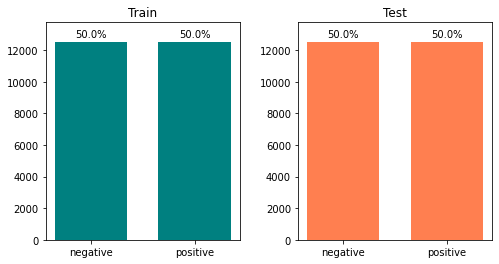

In [16]:
def plot_distribution(train_labels, test_labels, classes):
    '''class distribution'''
    def plot_dist(labels, title, color='blue', width = 0.7):        
        bin_count = np.bincount(labels)       
        bin_percentage = bin_count/len(labels)
        rects = plt.bar(classes, bin_count, width, color=color)
        plt.title(title)
        plt.ylim(0,max(bin_count)*1.1) 
        
        for i, r in enumerate(rects):
            plt.annotate('{:0.1f}%'.format(int(bin_percentage[i]*100)),
                        xy=(r.get_x() + r.get_width() / 2, r.get_height()),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')        

    classes_count = len(classes)            
    height = min(16, classes_count*4)
    plt.figure(figsize=(height, 4))
    plt.subplot(121)
    plot_dist(train_labels, 'Train', color='teal')
    plt.subplot(122)
    plot_dist(test_labels, 'Test', color='coral')
    
    plt.subplots_adjust(wspace=0.3, hspace=0.3) 
    plt.show()    

classes=['negative', 'positive']    
plot_distribution(train_labels, test_labels, classes)

![image-20201217123826241](images/image-20201217123826241.png)

### Sample Length Distribution

Check if the sample length in train dataset is similar as that in test dataset.

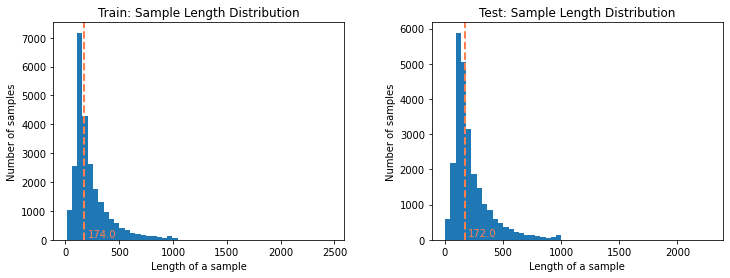

In [7]:
def plot_length_distribution(train_text_lengths, test_text_lengths):
    
    def plot_length_dist(lengths, title):
        median = np.median(lengths)
        plt.hist(lengths, 50)
        plt.axvline(x=median, color='coral', linestyle='dashed', linewidth=2)
        plt.text(median+30, 100, median, color='coral')
        plt.xlabel('Length of a sample')
        plt.ylabel('Number of samples')
        plt.title('{}: Sample Length Distribution'.format(title))          


    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plot_length_dist(train_text_lengths, 'Train')
    plt.subplot(122)
    plot_length_dist(test_text_lengths, 'Test')
    
    plt.subplots_adjust(wspace=0.3, hspace=0.3) 
    plt.show()    

    
train_text_lengths = [len(s.split()) for s in train_texts]
test_text_lengths = [len(s.split()) for s in test_texts]
plot_length_distribution(train_text_lengths, test_text_lengths)

![image-20201217131542940](images/image-20201217131542940.png)

### Frequency Distribution of Words

Check if the frequency distribution in train dataset is similar as that in test dataset.

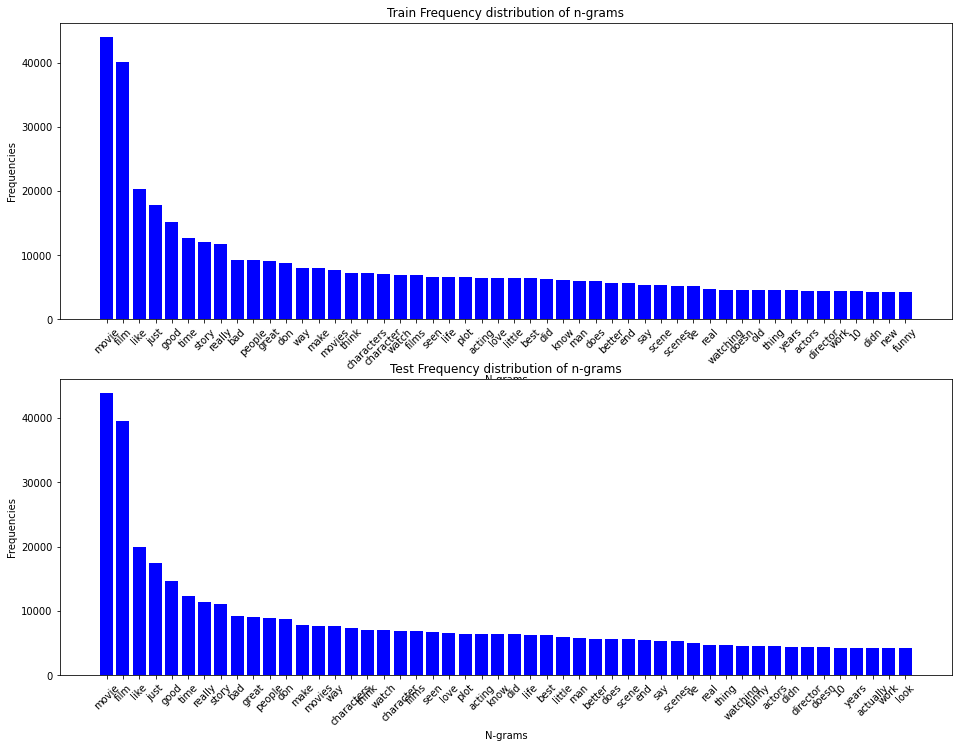

In [16]:
def plot_frequency_distribution_of_ngrams(sample_texts,
                                          ngram_range=(1, 2),
                                          num_ngrams=50,
                                          stop_words=None,
                                          title=''
                                         ):
    """Plots the frequency distribution of n-grams.
    # Arguments
        samples_texts: list, sample texts.
        ngram_range: tuple (min, mplt), The range of n-gram values to consider.
            Min and mplt are the lower and upper bound values for the range.
        num_ngrams: int, number of n-grams to plot.
            Top `num_ngrams` frequent n-grams will be plotted.
    """
    # Create args required for vectorizing.
    kwargs = {
            'ngram_range': (1, 1),
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
            'stop_words': stop_words
    }
    vectorizer = text.CountVectorizer(**kwargs)

    # This creates a vocabulary (dict, where keys are n-grams and values are
    # idxices). This also converts every text to an array the length of
    # vocabulary, where every element idxicates the count of the n-gram
    # corresponding at that idxex in vocabulary.
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all n-grams in the index order from the vocabulary.
    all_ngrams = list(vectorizer.get_feature_names())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    # ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]

    idx = np.arange(num_ngrams)
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('N-grams')
    plt.ylabel('Frequencies')
    plt.title('{} Frequency distribution of n-grams'.format(title))
    plt.xticks(idx, ngrams, rotation=45)


def plot_frequency_distribution(train_texts, test_texts) :  
    stop_words = text.ENGLISH_STOP_WORDS.union(["br"])
    plt.figure(figsize=(16, 12))
    plt.subplot(211)
    plot_frequency_distribution_of_ngrams(train_texts, title='Train', stop_words=stop_words)  
    plt.subplot(212)
    plot_frequency_distribution_of_ngrams(test_texts, title='Test', stop_words=stop_words)   
    plt.show()
   


plot_frequency_distribution(train_texts, test_texts)

In [9]:
word_counter = Counter()
for s in train_texts:
    word_counter.update(s.split())
for s in test_texts:
    word_counter.update(s.split())   

print('Number of Vocabulary: {}'.format(len(word_counter)))

for word in list(word_counter):
    if word_counter[word]<100: word_counter.pop(word)
        
print('Number of Vocabulary: {}'.format(len(word_counter)))

Number of Vocabulary: 438729
Number of Vocabulary: 7706


![image-20201217142728260](images/image-20201217142728260.png)

## Prepare Data

Different models need to different data. So we need to choose a model first. 

### Choose a Model

Below is a flowchart from Google as a starting point to construct the first model. We can apply it in our POC. 

![image-20201217135347743](images/image-20201217135347743.png)

1. Calculate the number of samples/number of words per sample ratio.
2. If this ratio is less than 1500, tokenize the text as n-grams and use a simple multi-layer perceptron (MLP) model to classify them (left branch in the flowchart below):
  a. Split the samples into word n-grams; convert the n-grams into vectors.
  b. Score the importance of the vectors and then select the top 20K using the scores.
    c. Build an MLP model.
3. If the ratio is greater than 1500, tokenize the text as sequences and use a sepCNN model to classify them (right branch in the flowchart below):
     a. Split the samples into words; select the top 20K words based on their frequency.
    b. Convert the samples into word sequence vectors.
    c. If the original number of samples/number of words per sample ratio is less   than 15K, using a fine-tuned pre-trained embedding with the sepCNN  model will likely provide the best results.
4. Measure the model performance with different hyperparameter values to find
   the best model configuration for the dataset.

In [10]:
length_median = np.median(train_text_lengths)
train_number = len(train_texts)
print ("[the number of samples]/[number of words per sample] = {:0.1f}".format(train_number/length_median))

[the number of samples]/[number of words per sample] = 143.7


![image-20201217144321430](images/image-20201217144321430.png)

Though the ratio is leas than 1500, we still use RNN as the following model. Because RNN and its extended models (such as Transformer, BERT) show much powerful performance than MLP for 5 years.  

In real project, we will build MLP model first and then also build RNN model, and they are both the baselines of the performance.





First,  clean unused folder.

In [18]:
train_dir = os.path.join(dataset_dir, 'train')
print(os.listdir(train_dir))
remove_dir = os.path.join(train_dir, 'unsup')
if os.path.exists(remove_dir):
    shutil.rmtree(remove_dir)
print(os.listdir(train_dir))


['neg', 'pos', 'unsupBow.feat', 'labeledBow.feat', 'urls_neg.txt', 'urls_pos.txt', 'urls_unsup.txt']
['neg', 'pos', 'unsupBow.feat', 'labeledBow.feat', 'urls_neg.txt', 'urls_pos.txt', 'urls_unsup.txt']


### N-grams

### Sequence

In [12]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    os.path.join(dataset_dir, 'train'), 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

print('-'*100)
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    os.path.join(dataset_dir, 'train'), 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

print('-'*100)
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    os.path.join(dataset_dir, 'test'), 
    batch_size=batch_size)

for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print('-'*50, label_batch.numpy()[i], '-'*50)
        print(text_batch.numpy()[i])
        
print('-'*100)
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])       

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
----------------------------------------------------------------------------------------------------
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
----------------------------------------------------------------------------------------------------
Found 25000 files belonging to 2 classes.
-------------------------------------------------- 0 --------------------------------------------------
b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, b

![image-20201217152912385](images/image-20201217152912385.png)

#### Token to Vector

The following function will remove the  punctuations or HTML elements to simplify the dataset.

In [ ]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Next, we will create a `TextVectorization` layer. we will use this layer to standardize, tokenize, and vectorize our data.

In [ ]:
max_features = 10000
sequence_length = 250

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

print("7 ---> ",vectorize_layer.get_vocabulary()[7])
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

![image-20201217154849445](images/image-20201217154849445.png)

Next, we will convert the dataset from token to vector.

In [ ]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# cache data to improve the performance
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

At last, let's check the data.

In [ ]:
vector_batch, label_batch = next(iter(train_ds))
first_vector, first_label = vector_batch[0], label_batch[0]

print('Label：{}'.format(raw_train_ds.class_names[first_label]))
print('-'*50, 'Vector', '-'*50)
print(first_vector.numpy())
print('-'*50, 'orginal review', '-'*50)
print(' '.join([vectorize_layer.get_vocabulary()[v] for v in first_vector]))

![image-20201217155826393](images/image-20201217155826393.png)

## Build, Train & Evaluate Model

We will apply Embedding and GRU in the first model.

In [ ]:
def get_rnn(embedding_dim, dropput=0):
    model = tf.keras.Sequential([
        layers.Embedding(input_dim=max_features+1, output_dim=embedding_dim, mask_zero=True),
        layers.SimpleRNN(units=32),
        layers.Dense(units=1)])
    model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
                  optimizer='adam',
                  metrics=tf.metrics.BinaryAccuracy(threshold=0.0))    
    return model 

model = get_rnn(embedding_dim=32)
model.summary()  

![image-20201217163929440](images/image-20201217163929440.png)

In [ ]:
 tf.keras.utils.plot_model(model, '{}.png'.format(model.name), show_shapes=True) 

![image-20201217163943713](images/image-20201217163943713.png)

Next, let's start training.

In [ ]:
epochs = 5
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

![image-20201217164441244](images/image-20201217164441244.png)

Next, let's evaluate the model

In [ ]:
def plot_history(history):
    '''显示训练的loss和accuracy的走势图'''
    plt.figure(figsize=(12, 5))
    epochs = range(1, len(history.history['binary_accuracy'])+1)
    plt.subplot(121)
    plt.plot(epochs, history.history['binary_accuracy'])
    plt.plot(epochs, history.history['val_binary_accuracy'])
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.xticks(epochs)
    plt.legend(['Training', 'Validation'], loc='lower right')

    plt.subplot(122)
    plt.plot(epochs, history.history['loss'])
    plt.plot(epochs, history.history['val_loss'])
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(epochs)
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show() 
    
def evaluate(test_ds):
    loss, accuracy = model.evaluate(test_ds, verbose=False)
    print("Loss: {:0.5f}, Accuracy: {:0.1f}%".format(loss, accuracy*100))

plot_history(history)    
evaluate(test_ds)    

![image-20201217164722084](images/image-20201217164722084.png)

The diagram shows that the model is a serious over-fitting.   But the Accuracy is 85%. It is not bad and It can be the baseline. Next we can consider to optimize the model or choose better model.  There are many models coming in the recent years. We can try some of them and choose the better one.

For IMBD dataset, here is state of art. The best model can get 96.8 accuracy. It's really good result. Maybe, we can consider to implement it by ourselves.

![image-20201217170631096](images/image-20201217170631096.png)

## Tune Hyperparameters 

After we choose a model, we still can optimize it by choosing better hyperparameters.

We had to choose a number of hyperparameters for defining and training the model. We relied on intuition, examples and best practice recommendations. Our first choice of hyperparameter values, however, may not yield the best results. 

- **Number of layers in the model**: The number of layers in a neural network is an indicator of its complexity. We must be careful in choosing this value. Too many layers will allow the model to learn too much information about the training data, causing overfitting. Too few layers can limit the model’s learning ability, causing underfitting. For text classification datasets, we experimented with one, two, and three-layer MLPs. Models with two layers performed well, and in some cases better than three-layer models. Similarly, we tried sepCNNs with four and six layers, and the four-layer models performed well.
- **Number of units per layer**: The units in a layer must hold the information for the transformation that a layer performs. For the first layer, this is driven by the number of features. In subsequent layers, the number of units depends on the choice of expanding or contracting the representation from the previous layer. Try to minimize the information loss between layers. We tried unit values in the range `[8, 16, 32, 64]`, and 32/64 units worked well.
- **Dropout rate**: Dropout layers are used in the model for [regularization](https://developers.google.com/machine-learning/glossary/?utm_source=DevSite&utm_campaign=Text-Class-Guide&utm_medium=referral&utm_content=glossary&utm_term=dropout-regularization#dropout_regularization). They define the fraction of input to drop as a precaution for overfitting. Recommended range: 0.2–0.5.
- **Learning rate**: This is the rate at which the neural network weights change between iterations. A large learning rate may cause large swings in the weights, and we may never find their optimal values. A low learning rate is good, but the model will take more iterations to converge. It is a good idea to start low, say at 1e-4. If the training is very slow, increase this value. If your model is not learning, try decreasing learning rate.

## Deploy Your Model

If we get a good model, we will start to consider to deploy the model. We will consider a lot of things. 

- Which platform will we use?

  Cloud(AWS or Azure) or own server. If the model uses the deep learning technology, maybe, we can consider to choose a server which has GPU. 

- Automate the prediction

  We need to connect the prediction with other applications and make everything run automatically

- Model Refreshment

  Sometimes we need to re-train the model because of some causes, for example, data change, business logic change, new better model. We need to provide a mechanism to refresh the model smoothly. 

- Cyber Security 

  ...

In [4]:
import tensorflow as tf
tf.nn.softmax([2.0, 3.0]).numpy()

array([0.26894143, 0.7310586 ], dtype=float32)